# Flower Classification using VGG16 Model

### Importing Dependencies

In [75]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
tf.config.experimental.get_device_details(tf.config.experimental.list_physical_devices()[1])

{'compute_capability': (6, 1), 'device_name': 'NVIDIA GeForce GTX 1070'}

### Load Flower Dataset
Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset

No. of Classes: 5

Classes: Lilly, Lotus, Orchid, Sunflower, Tulip

Total Images: 5000 

In [3]:
input_shape = (224, 224, 3)
image_shape = (224, 224)
num_classes = 5
batch_size = 32

train_data, val_data = keras.utils.image_dataset_from_directory('flower_images', batch_size=batch_size, image_size=image_shape, label_mode='categorical', seed=225, validation_split= 0.2, subset='both')

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Using 999 files for validation.


### Model Definition

In [9]:
def vgg16_block(filters, name):
    
    return keras.Sequential([
        keras.layers.Conv2D(filters=filters, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=filters, kernel_size=3, strides=(1,1), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(pool_size=2),
    ], name=name)

In [14]:
input = keras.Input(shape=input_shape)

block1 = vgg16_block(filters=64, name='block1')(input)
block2 = vgg16_block(filters=128, name='block2')(block1)
block3 = vgg16_block(filters=256, name='block3')(block2)
block4 = vgg16_block(filters=512, name='block4')(block3)
block5 = vgg16_block(filters=512, name='block5')(block4)

# Classifier Block
x = keras.layers.Flatten()(block5)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
output = keras.layers.Dense(units=num_classes, activation='softmax')(x)


model = keras.Model(inputs=input, outputs=output, name='VGG16')
model.summary(expand_nested=True)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1 (Sequential)         (None, 112, 112, 64)      38976     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_20 (Conv2D)        (None, 224, 224, 64)      1792      |
|                                                               |
| conv2d_21 (Conv2D)        (None, 224, 224, 64)      36928     |
|                                                               |
| batch_normalization_10 (Bat  (None, 224, 224, 64)   256       |
| chNormalization)                                              |
|                                                               |
| re_lu_10 (ReLU)           (None, 224, 224, 64)      0         |
|                                                            

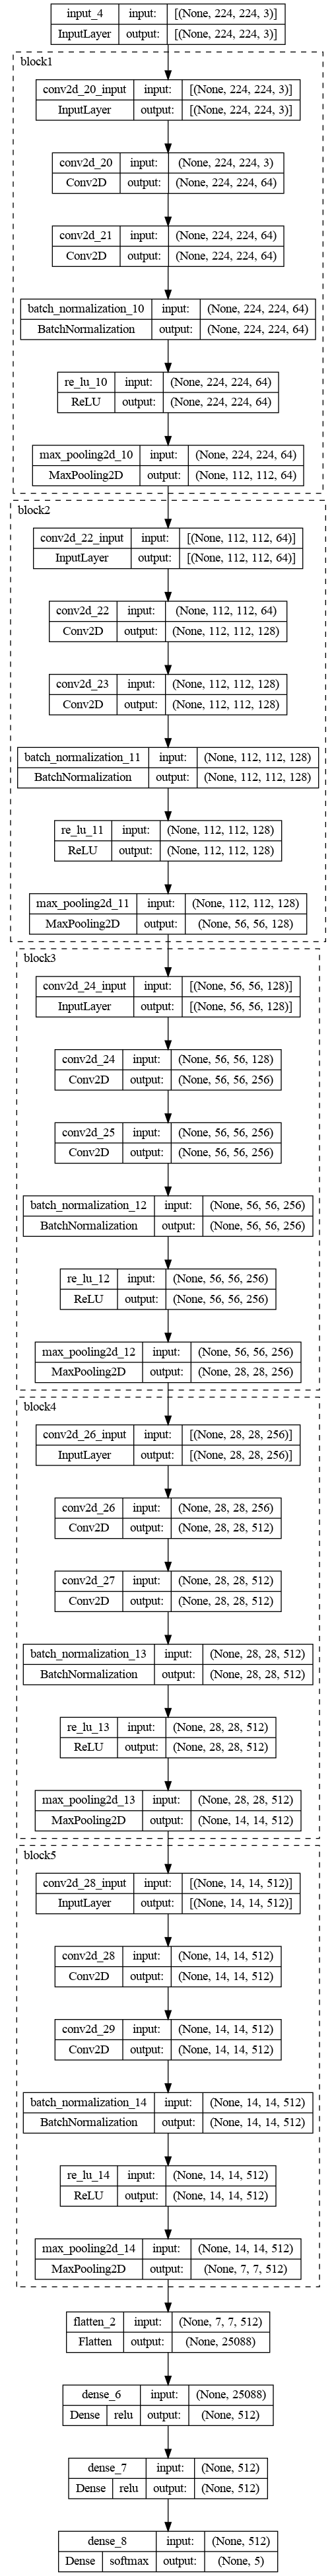

In [15]:
keras.utils.plot_model(model, to_file='VGG16_with_bn.png', show_layer_activations=True, show_shapes=True, expand_nested=True)

### Model Training

In [18]:
def lr_schedule(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        return lr / 10
    else:
        return lr
    
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.LearningRateScheduler(lr_schedule), 
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/vgg16_bn.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [19]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_data, epochs=100, batch_size=batch_size, validation_data=val_data, callbacks=callbacks, verbose='auto')

Epoch 1/100


125/125 [==============================] - 58s 410ms/step - loss: 3.2588 - accuracy: 0.2697 - val_loss: 4.0686 - val_accuracy: 0.3143 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 57s 452ms/step - loss: 1.3529 - accuracy: 0.4340 - val_loss: 1.4482 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 55s 437ms/step - loss: 1.2257 - accuracy: 0.5042 - val_loss: 1.2103 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 53s 418ms/step - loss: 1.1703 - accuracy: 0.5210 - val_loss: 1.2467 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 54s 427ms/step - loss: 1.1408 - accuracy: 0.5320 - val_loss: 1.0914 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 6/100
125/125 [==============================] - 55s 433ms/step - loss: 1.1109 - accuracy: 0.5515 - val_loss: 1.1604 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 7/100
125/125 [==============================] - 53s

In [21]:
model.load_weights('checkpoints/vgg16_bn.h5')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'loss')]

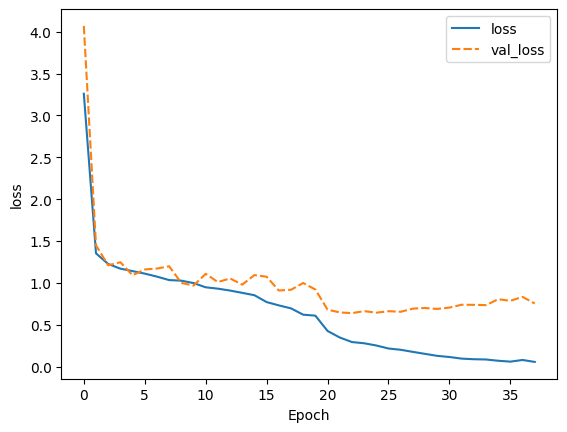

In [80]:
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
ax.set(xlabel='Epoch', ylabel='loss')

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy')]

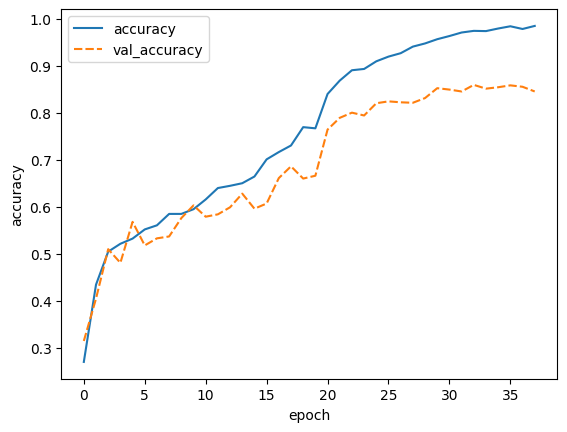

In [81]:
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})
ax.set(xlabel='epoch', ylabel='accuracy')

In [69]:
def plot_prediction(preds, x, y, index=0):
    prediction = np.argmax(preds[index])
    label = np.argmax(y[index])
    # print(prediction, label)
    print(f'Class: {val_data.class_names[label]}\nPredicted: {val_data.class_names[prediction]}')
    plt.imshow(x[index].numpy().astype(np.uint8))

In [62]:
for x, y in val_data:
    x = x
    labels = y
    break    
x.shape
preds = model.predict(x)

1/1 [==============================] - 0s 53ms/step


Class: Orchid
Predicted: Orchid


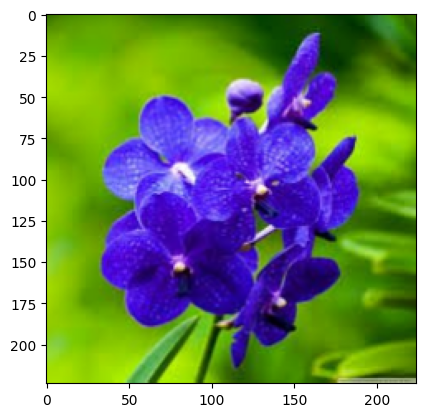

In [74]:
plot_prediction(preds, x, y, 8)